# Machine learning for remote sensing: Lecture 2

Simon Pfreundschuh (simon.pfreundschuh@colostate.edu)

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split

n_samples = 10_000
input_data = np.random.uniform(-5, 5, size=n_samples)
target_data = 0.05 * input_data ** 2 + np.sin(input_data) + 0.5 * np.random.normal(size=input_data.size)
training_dataset = TensorDataset(
    torch.tensor(input_data).to(dtype=torch.float32).reshape(-1, 1),
    torch.tensor(target_data).to(dtype=torch.float32).reshape(-1, 1),
)
training_dataset, validation_dataset = random_split(training_dataset, [0.8, 0.2])
training_loader = DataLoader(training_dataset, batch_size=1024, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=1024, shuffle=False)

simple_nn = nn.Sequential(
    nn.Linear(1, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)

## Recap

<div style="text-align: center;">
  <img src="../figures/ml_ingredients_recap_full.svg" alt="Example scene from the IPWG precipitation retrieval benchmark dataset" width="800"/>
</div>

### Precipitation retrieval results

- Retrieval accuracy metrics from a slightly modified fully-connected neural network retrieval.
- Compared to a gradient-boosted-tree model implemented using [XGBoost](https://xgboost.readthedocs.io/en/stable/)
- Model configuration:
  - 5 layers
  - 256 neurons
  - GELU activation function
  - Adam optimizer, Cosine annealing learning rate schedule, initial LR = $1e-3$
  - 40 epochs

<div style="text-align: center;">
  <img src="../figures/mlp_retrieval_metrics.png" alt="Example scene from the IPWG precipitation retrieval benchmark dataset" width="800"/>
</div>

## More concise training with ``lightning``

- The code presented in the previous lecture required us to write our own training loop:

In [2]:
from torch.optim import SGD
from tqdm import tqdm
optimizer = SGD(simple_nn.parameters())

n_epochs = 11
loss_fn = nn.MSELoss()

for epoch_index in tqdm(range(n_epochs)):

    epoch_loss = 0.0
    
    for x_b, y_b in training_loader:
        
        loss = loss_fn(y_b, simple_nn(x_b))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # The item() function extract the floating point value of the loss and
        # avoid PyTorch from further tracking gradients.
        epoch_loss += loss.item()

    if epoch_index % 10 == 1:
        print(f"Epoch {epoch_index}, loss: {epoch_loss / len(training_loader)}")

 36%|███████████████████████████████████████████████████████▋                                                                                                 | 4/11 [00:00<00:00, 12.72it/s]

Epoch 1, loss: 0.9390288218855858


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.88it/s]


- The PyTorch Lightning package builds on PyTorch and provides a lot of helpful functionality to simplify the training of PyTorch models
- Importantly: PyTorch Lightning makes it a breeze to train your model on one or multiple GPUs.
- It's pretty much the go-to package for state-of-the-art NN models.
- Our simple NN can be implemented using PyTorch Lightning as follows:

In [3]:
from torch import nn
import lightning as lit

class LightningModule(lit.LightningModule):
    """
    A lightning module defines how to evaluate the training and validation losses of our
    neural network models, and the setup of the optimizer. This is sufficient to leave all
    other details of the training to Pytorch lightning.
    """
    def __init__(
        self,
        model,
        loss_fn = nn.MSELoss(),
        optim = torch.optim.SGD,
        lr_scheduler = None,
        lr=1e-3
    ):
        """
        Create the lightning module.

        Args:
            model: The nn.Module to train
            loss_fn: A PyTorch callable defining the loss function
            optim: The optimizer class to use for optimization.
            lr_scheduler: An optional learning-rate scheduler.
            lr: The inital learning rate.
        """
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.optim = optim
        self.lr_scheduler = lr_scheduler
        self.lr = lr

    def forward(self, x):
        """
        Propage tensor through model.
        """
        return self.model(x)

    def training_step(self, batch, *args):
        """
        Calculate loss for a single training step.
        """
        x, y = batch
        y_pred = self(x)
        loss = self.loss_fn(y, y_pred)
        self.log("Training loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, *args):
        """
        Calculate loss for a single validation step.
        """
        x, y = batch
        y_pred = self(x)
        loss = self.loss_fn(y_pred, y)
        self.log("Validation loss", loss, prog_bar=True)

    def configure_optimizers(self):
        """
        Configure optimizer and scheduler for the training.
        """
        optim = self.optim(self.parameters(), self.lr)
        config = {"optimizer": optim}
        if self.lr_scheduler is not None:
            config["lr_scheduler"] = self.lr_scheduler(optim)
        return config


In [4]:
simple_nn = nn.Sequential(
    nn.Linear(1, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)
lit_nn = LightningModule(
    simple_nn,
    nn.MSELoss(),
    SGD
)
trainer = lit.Trainer(max_epochs=5, log_every_n_steps=1)
trainer.fit(lit_nn, train_dataloaders=training_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/simon/miniconda3/envs/at652/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 33.4 K | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
33.4 K    Trainable params
0         Non-trainable params
33.4 K    Total params
0.134     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
/home/simon/miniconda3/envs/at652/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_wor

Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=5` reached.


## Optimizers and learning rate schedules


- The basic ideas behind SGD were crucial to allow us to scale the NN training to large datasets
- However, as we have seen, the convergence of SGD can be slow.
- Several optimizers have been designed to overcome these issues:

| Optimizer            | Basic Idea   | Effect |
|----------------------|--------------|--------|
| **SGD with momentum** | Adds a momentum term to the gradient. | Reduces noise, helps push through shallow minima|
| **RMSProp**          | Normalizes gradients by dividing by an exponentially moving average of recent gradients. |  Accelerates progress in flat areas of the LL | Accelerates progress in flat directions of the LL, dampens progress in steep directions |
| **AdaGrad**          | Adjusts learning rates for each parameter individually so that the learning rate for parameters receiving many updates is automatically lowered.  | Gradually decreases learning rates speeding up convergence.
| **Adam**  (⬅️ this one never let me down)           | Combines Momentum and RMSProp by maintaining averages of both past gradients and past squared gradients.        | Increases speed and stability of convergence |

> This may look more complicated than it is. The current consensus seems to be: Adam (or AdamW) does the job.

### Learning rate schedules

- Neural network training generally benefits from decreasing the learning rate over time.
- Some models also use a warm up, i.e., a ramping of of the learning rate, at the beginning of the training.
- Common approaches for learning rate scheduling are:

| Learning Rate Schedule        | Description                                                                                     |
|-------------------------------|-------------------------------------------------------------------------------------------------|
| **Step Decay**                | Reduces the learning rate by a fixed factor (e.g., 0.1) at specified intervals (e.g., every N epochs). |
| **Cosine Annealing**          | Uses a cosine function to vary the learning rate, gradually decreasing it to zero in a smooth curve.  |
| **Cyclical Learning Rate**    | Cycles the learning rate between a minimum and maximum value, often following triangular or sinusoidal waves, to help escape local minima. |
| **Reduce on Plateau**         | Lowers the learning rate when the validation loss plateaus for a certain number of epochs, helping avoid overfitting or stagnation. |

> My go-to choice: Cosine annealing with restarts (Loshchilov, 2016)


## Monitoring training progress

- Monitoring the training progress is a crucial part of training a neural network
- At the very least, you should be monitoring training and validation losses
- Additionally, it can be helpful to monitor additional metrics or plot sample results

### Over- and underfitting
 - Overfitting occurs when the model learns spurious relationships from the training data. This occurs when the model is too complex and the training dataset too small.
 - Underfitting occurs when the model is not expressive enough to fit the training data

In [7]:
from functools import partial
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from lightning.pytorch.loggers import CSVLogger

def fit_simple_nn(
    x,
    y,
    n_neurons,
    n_epochs,
    experiment_name
):
    training_dataset = TensorDataset(x, y)
    training_dataset, validation_dataset = random_split(training_dataset, [0.8, 0.2])
    training_loader = DataLoader(training_dataset, batch_size=256, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=256, shuffle=False)
    
    simple_nn = nn.Sequential(
        nn.Linear(1, n_neurons),
        nn.ReLU(),
        nn.Linear(n_neurons, n_neurons),
        nn.ReLU(),
        nn.Linear(n_neurons, n_neurons),
        nn.ReLU(),
        nn.Linear(n_neurons, 1)
    )
    lit_nn = LightningModule(
        simple_nn,
        nn.MSELoss(),
        lr=1e-2,
        optim=Adam,
        lr_scheduler=partial(CosineAnnealingLR, T_max=n_epochs)
    )
    trainer = lit.Trainer(
        max_epochs=n_epochs,
        logger=CSVLogger("lightning_logs", name=experiment_name, version=0),
        log_every_n_steps=1
    )
        
    trainer.fit(lit_nn, train_dataloaders=training_loader, val_dataloaders=validation_loader)
    return simple_nn

x = torch.tensor(input_data).to(torch.float32).reshape(-1, 1)
y = torch.tensor(target_data).to(torch.float32).reshape(-1, 1)
simple_nn_overfit = fit_simple_nn(x[:100], y[:100], 256, 400, "overfit")
simple_nn_underfit = fit_simple_nn(x, y, 3, 20, "underfit")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/simon/miniconda3/envs/at652/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory lightning_logs/overfit/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/simon/miniconda3/envs/at652/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory lightning_logs/overfit/version_0/checkpoints exists and is not empty.

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 132 K  | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.529     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval 

Sanity Checking: |                                                                                      | 0/? …

/home/simon/miniconda3/envs/at652/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                                                                             | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/simon/miniconda3/envs/at652/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory lightning_logs/underfit/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/simon/miniconda3/envs/at652/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory lightning_logs/underfit/version_0/checkpoints exists and is not empty.

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 34     | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
9      

Sanity Checking: |                                                                                      | 0/? …

Training: |                                                                                             | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

`Trainer.fit` stopped: `max_epochs=20` reached.


Text(0, 0.5, 'Target data')

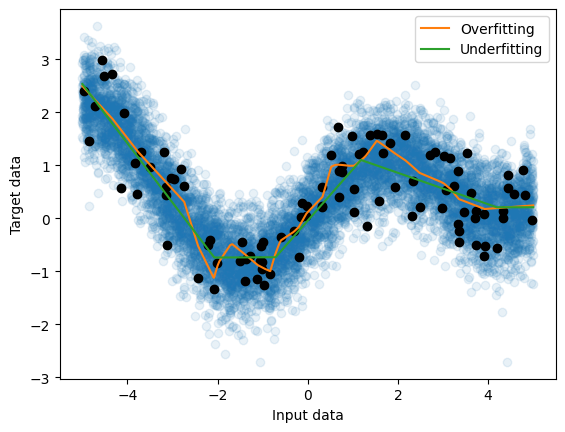

In [8]:
import matplotlib.pyplot as plt

x_eval = torch.linspace(-5, 5, 1001).reshape(-1, 1)
with torch.no_grad():
    y_overfit = simple_nn_overfit(x_eval).flatten().numpy()
    y_underfit = simple_nn_underfit(x_eval).flatten().numpy()

f, ax = plt.subplots(1, 1)
ax.scatter(input_data, target_data, alpha=0.1)
ax.scatter(x[:100], y[:100], c="k")
ax.plot(x_eval.numpy(), y_overfit, c="C1", label="Overfitting")
ax.plot(x_eval.numpy(), y_underfit, c="C2", label="Underfitting")
ax.legend()
ax.set_xlabel("Input data")
ax.set_ylabel("Target data")

### Training and validation loss
 - Comparing training and validation loss curves can help diagnosing both issues
 - **Increasing validation loss is a dead giveaway for overfitting**
 - Underfitting
 

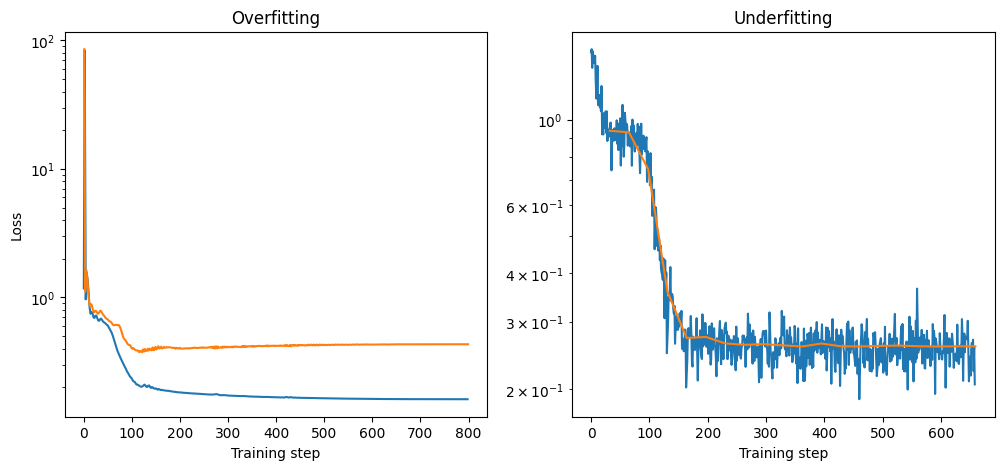

In [147]:
import pandas as pd
stats_overfit = pd.read_csv("lightning_logs/overfit/version_0/metrics.csv")
stats_underfit = pd.read_csv("lightning_logs/underfit/version_0//metrics.csv")

f, axs = plt.subplots(1, 2, figsize=(12, 5))

ax = axs[0]
stats_overfit_train = stats_overfit["Training loss"].dropna()
stats_overfit_val = stats_overfit["Validation loss"].dropna()
ax.plot(stats_overfit_train)
ax.plot(stats_overfit_val)
ax.set_title("Overfitting")
ax.set_yscale("log")
ax.set_xlabel("Training step")
ax.set_ylabel("Loss")

ax = axs[1]
ax.set_title("Underfitting")
stats_underfit_train = stats_underfit["Training loss"].dropna()
stats_underfit_val = stats_underfit["Validation loss"].dropna()
ax.plot(stats_underfit_train)
ax.plot(stats_underfit_val)
ax.set_xlabel("Training step")
ax.set_yscale("log")


## Regularization

- Regularization offers an alternative approach to avoid overfitting
- Multiple possible approaches:
    - Adding a term to the loss function that penalizes model complexity ($L_1$ or $L_2$ normalization)
    - Randomly drop parts of the model (Dropout)

### Example
- L2-normalization is also know as weight decay
- In PyTorch, it can be activated through the optimizer

In [14]:
from functools import partial

def fit_simple_nn(
    x,
    y,
    n_neurons,
    n_epochs,
    experiment_name
):
    training_dataset = TensorDataset(x, y)
    training_dataset, validation_dataset = random_split(training_dataset, [0.8, 0.2])
    training_loader = DataLoader(training_dataset, batch_size=256, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=256, shuffle=False)
    
    simple_nn = nn.Sequential(
        nn.Linear(1, n_neurons),
        nn.ReLU(),
        nn.Linear(n_neurons, n_neurons),
        nn.ReLU(),
        nn.Linear(n_neurons, n_neurons),
        nn.ReLU(),
        nn.Linear(n_neurons, 1)
    )
    lit_nn = LightningModule(
        simple_nn,
        nn.MSELoss(),
        lr=1e-2,
        optim=partial(Adam, weight_decay=1e-1),
        lr_scheduler=partial(CosineAnnealingLR, T_max=n_epochs)
    )
    trainer = lit.Trainer(
        max_epochs=n_epochs,
        logger=CSVLogger("lightning_logs", name=experiment_name, version=0),
        log_every_n_steps=1, # Log every step because training is short anyways.
        enable_progress_bar=False
    )
        
    trainer.fit(
        lit_nn,
        train_dataloaders=training_loader,
        val_dataloaders=validation_loader,
    )
    return simple_nn

simple_nn_overfit_l2 = fit_simple_nn(x[:100], y[:100], 256, 200, "overfit_l2")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 132 K  | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.529     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=200` reached.


### Results

- Weight decay dampens high-frequency oscillations in the results

Text(0, 0.5, 'Target data')

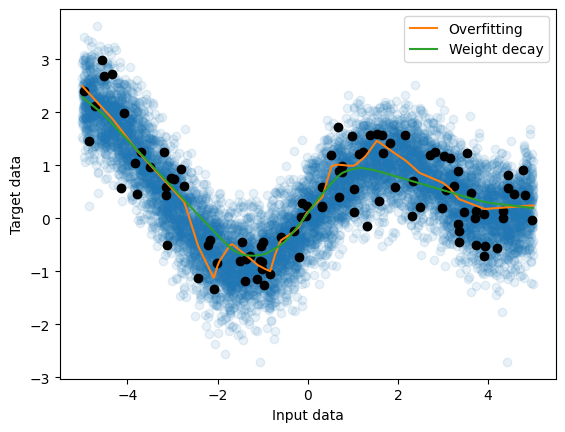

In [16]:
import matplotlib.pyplot as plt

x_eval = torch.linspace(-5, 5, 1001).reshape(-1, 1)
with torch.no_grad():
    y_overfit_l2 = simple_nn_overfit_l2(x_eval).flatten().numpy()
    
f, ax = plt.subplots(1, 1)
ax.scatter(input_data, target_data, alpha=0.1)
ax.scatter(x[:100], y[:100], c="k")
ax.plot(x_eval.numpy(), y_overfit, c="C1", label="Overfitting")
ax.plot(x_eval.numpy(), y_overfit_l2, c="C2", label="Weight decay")
ax.legend()
ax.set_xlabel("Input data")
ax.set_ylabel("Target data")

- For this example the regularization successfully avoids the model from overfitting resulting in a lower overall validation loss.

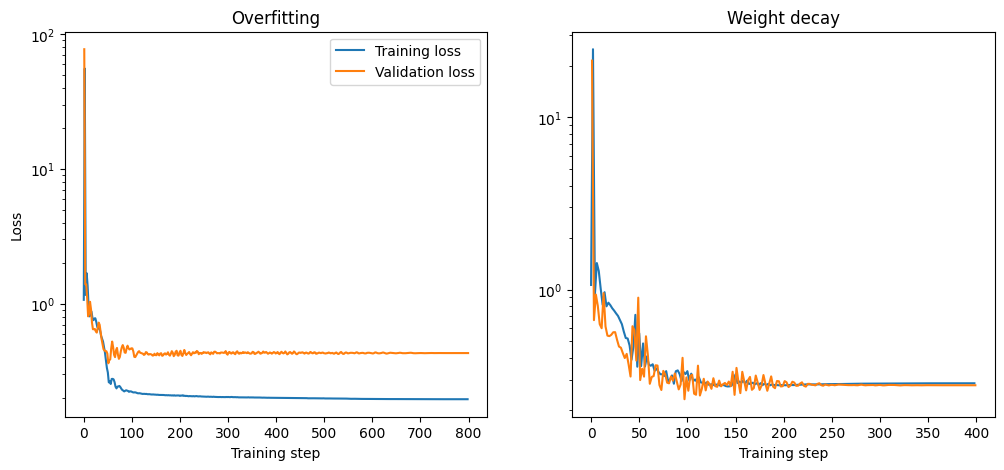

In [17]:
import pandas as pd
stats_overfit = pd.read_csv("lightning_logs/overfit/version_0/metrics.csv")
stats_overfit_l2 = pd.read_csv("lightning_logs/overfit_l2/version_0/metrics.csv")

f, axs = plt.subplots(1, 2, figsize=(12, 5))

ax = axs[0]
stats_overfit_train = stats_overfit["Training loss"].dropna()
stats_overfit_val = stats_overfit["Validation loss"].dropna()
ax.plot(stats_overfit_train, label="Training loss")
ax.plot(stats_overfit_val, label="Validation loss")
ax.set_title("Overfitting")
ax.set_yscale("log")
ax.set_xlabel("Training step")
ax.set_ylabel("Loss")
ax.legend()

ax = axs[1]
ax.set_title("Weight decay")
stats_overfit_l2_train = stats_overfit_l2["Training loss"].dropna()
stats_overfit_l2_val = stats_overfit_l2["Validation loss"].dropna()
ax.plot(stats_overfit_l2_train)
ax.plot(stats_overfit_l2_val)
ax.set_xlabel("Training step")
ax.set_yscale("log")

## Loss functions

- The loss function determines what your model is learning
- Different tasks typically require different loss function
- Some of the most commonly used are:

| Loss Function                  | Application              | Model output                | Reference value | Formula    |
|--------------------------------|--------------------------|-----------------------------|-----------------|------------|
| **Mean Squared Error (MSE)**   | Regression               | Predicted value             |  Reference value|  $\mathcal{L}(y, \hat{y}) = (y - \hat{y})^2$ |
| **Mean Absolute Error (MAE)**  | Regression               | Model output                |  Reference value|  $\mathcal{L}(y, \hat{y}) = |y - \hat{y})^2|$ |
| **Binary Cross-Entropy**       | Binary classfication     | Probabilty of class being 1 |   0 or 1        |  $\mathcal{L}(y, \hat{y}) =  -\log(\hat{y})y - \log(1  - \hat{y})(1 - y) $ |
| **Categorical Cross-Entropy**  | Multi-class classfication| Vector of class probabilities    |  Class index    |$\mathcal{L}(y, \hat{y}) =  -\log(\hat{y}_y)$ |



### Special considerations for classficiation tasks

 - For classficiation, we typically train models to predict probabilities
 - To obtain proper probabilities, we typically use squashing functions:
    - Sigmoid for binary clasffication: $\sigma(x) = \frac{1}{1 + \exp(-x)}$
    - Softmax for multi class clasffication: $\text{softmax}(x)_i = \frac{\exp(x_i)}{\sum_j^N \exp (x_j)}$
 - For computational reasons, however, the sigmoid/softmax functions are typically combined with the loss function. This is the case for the PyTorch ``BCEWithLogitsLoss`` and ``CrossEntropy`` losses.
 - The pre-activation outputs from the model are called *logits*.
 - During inference, it is therefore necessary to apply the sigmoid/softmax functions separately to obtain proper probabilities

## Advanced model architectures

### Convolutional neural networks

- Convolutional neural networks (CNNs) are NN models designed for application to images
- They employ convolution layers, which apply learnable convolution kernels to the input image
- For dense prediction tasks, i.e., input and output are both images, the most common architecture is the UNet or encoder-decoder architecture
- Example of a CNN used for cloud-property retrievals (Amell, 2024):

<div style="text-align: center;">
  <img src="../figures/cnn.png" alt="Example of a CNN used for ice water path retrievals." width="800"/>
</div>

### Transformer
  - Transformers are NN models designed for application to sequences
  - They consist of so-called attention layers combined with fully-connected layers
  - They can be adapted to be applied to images or regular grids
  - Below an example the transformer used by the Prithvi WxC model for weather and climate applications (Schmude, 2024):
  
<div style="text-align: center;">
  <img src="../figures/transformer.png" alt="Example of a CNN used for ice water path retrievals." width="800"/>
</div>

## Summary and conclusions
### Conventional ML vs. deep learning

 - This lecture focused on deep learning for remote sensing because this is where (I think) we can expect the biggest improvements. Result below from Pfreundschuh (2024) compare retrieved precipitation from conventional retrievals (GPROF V7), a fully-connected NN (GPROF-NN 1D), and two CNN-based models (GPROF-NN 3D, GPROF-NN HR).
 - Particularly image-specific architectures (CNNs, vision transformers) allow leveraging structural information that current algorithms largely neglect
 - If you're in situation where you can obtain a large training dataset deep learning is the way to go.
 - However, simple NN also work well in scenarios with less data.

 <div style="text-align: center;">
  <img src="../figures/gprof_nn_case_study.png" alt="Case study of precipitation retrievals." width="800"/>
</div>

### Some words of caution

 1. Deep neural networks can pickup on unnoticed biases in your training data or blow up if the encounter unseen patterns.
    - **Always make sure to evaluate your network with realistic input data**
 2. Understanding the data you are working with is key.
 3. You don't always need the most fancy models. Most robust baselines (, e.g., ResNet) get you quit far. Also remember: We're typically dealing with relatively large uncertainties in our reference data.
 4. If your NN doesn't seem to learn anything, it's probably an likely issue with your code or your data.
    - Please contact me if you encounter an exception to this rule
     

### Conclusions

- 2 x 50 minutes are obviously not quite enough to cover the most complex models
- However, the basic princples introduced here remain the same.
- PyTorch Lightning is among the most popular frameworks for ML research
- Below my current go-to configuration (and strong contender for the next version of GPROF) for building precipitation retrievals:


<div style="text-align: center;">
  <img src="../figures/ml_ingredients_final.svg" alt="Example of a CNN used for ice water path retrievals." width="600"/>
</div>

## References

- Loshchilov, I. and Hutter, F.: SGDR: Stochastic gradient descent with warm restarts, arXiv [preprint], https://doi.org/10.48550/arXiv.1608.03983, 2016.
- Pfreundschuh, S., Eriksson, P., Duncan, D., Rydberg, B., Håkansson, N., and Thoss, A.: A neural network approach to estimating a posteriori distributions of Bayesian retrieval problems, Atmos. Meas. Tech., 11, 4627–4643, https://doi.org/10.5194/amt-11-4627-2018, 2018. 
- Tan, Mingxing, and Quoc Le. "Efficientnetv2: Smaller models and faster training." International conference on machine learning. PMLR, 2021.
- Amell, A., Pfreundschuh, S., and Eriksson, P.: The Chalmers Cloud Ice Climatology: retrieval implementation and validation, Atmos. Meas. Tech., 17, 4337–4368, https://doi.org/10.5194/amt-17-4337-2024, 2024. 
- Schmude, Johannes, et al. "Prithvi WxC: Foundation Model for Weather and Climate." arXiv preprint arXiv:2409.13598 (2024).